In [2]:
!pip install surprise
!pip uninstall tensorflow
!pip install tensorflow==1.15
!pip install annoy

     |████████████████████████████████| 11.8MB 5.3MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1618305 sha256=6a5a5b9a836d7211020dc0d33d0b8b9c0adf06b4a245d6c5d4d1eb60e1f128b5
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise
Uninstalling tensorflow-2.4.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.4.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.4.0
     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 512kB 44

## Imports

In [1]:
from surprise import Dataset, SVD, Reader,NMF
from surprise.model_selection import cross_validate,train_test_split
from surprise.model_selection import GridSearchCV,RandomizedSearchCV
from surprise import accuracy
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK,space_eval
import sys
import seaborn as sns
from timeit import Timer
from datetime import datetime
from surprise import Dataset, SVD, Reader,NMF
from surprise.model_selection import cross_validate,train_test_split
from surprise.model_selection import GridSearchCV,RandomizedSearchCV
from surprise import accuracy
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK,space_eval
from collections import defaultdict
import random
from sklearn.metrics import mean_squared_error
from numpy.linalg import inv
import pandas as pd
import numpy as np
import math
from numpy.linalg import inv
from numpy.linalg import multi_dot
import matplotlib.pyplot as plt
import itertools
import warnings
from ncf_singlenode import *
from dataset import Dataset as NCFDataset
from constants import SEED as DEFAULT_SEED
from python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)
SEED = DEFAULT_SEED
warnings.filterwarnings("ignore")

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = "1FFYnZRIuzQLeBkDUuJpK_oRtUmdxMd9O"

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('final_dataset.csv')  
data = pd.read_csv('final_dataset.csv')

In [3]:
data.drop(columns=['Unnamed: 0','timestamp','date','year'],inplace=True)

In [4]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))
def get_pred_data(all_predictions,test):
  data=pd.merge(all_predictions,test,on=['userID','itemID'],how='inner')
  return(data)
def pred_rank(pred):
    pred.sort_values(['userID', 'rating'], ascending=[True, False],inplace=True)
    pred["rating_rank"] = pred.groupby("userID")["rating"].rank("min", ascending=False)
    pred.sort_values(['userID', 'prediction'], ascending=[True, False],inplace=True)
    pred["pred_rank"] = pred.groupby("userID")["prediction"].rank("min", ascending=False)
    return(pred)
def test_all_for_ndcg(pred,data):
    data.sort_values(['userID', 'prediction'], ascending=[True, False],inplace=True)
    data["pred_rank"] = data.groupby("userID")["prediction"].rank("min", ascending=False)
    pred=pred[['userID','itemID','rating_rank','rating']]
    df = pd.merge(pred, data, on=['userID','itemID'],how='inner')
    return(df)



def ndcg_k(data1,k=10):
    data1['top_10_pred']=1
    data1.loc[(data1['pred_rank']>=k) ,'top_10_pred'] = 0
    data1['top_10_rating']=1
    data1.loc[(data1['rating_rank']>=k) ,'top_10_rating'] = 0
    data1['relevance']=data1['top_10_pred']*data1['top_10_rating']
    data1['log_den']=1/(np.log2(data1['pred_rank']+1))
    data1['dcg_num']=data1['relevance']*data1['log_den']
    data1["idcg_rank"] = data1.groupby("userID")["relevance"].rank("first", ascending=False)
    data1["idcg_log"]=1/(np.log2(data1['idcg_rank']+1))
    data1['idcg_num']=data1['relevance']*data1['idcg_log']
    user_list = data1['userID'].unique()
    ndcg=0
    len_ls=data1['userID'].nunique()
    for user in user_list:
      #print(user)
        _d=data1[data1['userID']==user]
        if _d['userID'].count()==1:
            len_ls=len_ls-1
        else:
            num=np.sum(data1[data1['userID']==user]['dcg_num'])
            den=np.sum(data1[data1['userID']==user]['idcg_num'])
            if den==0:
                continue
            else:
                ndcg+=num/den
            #break
    
    ndcg=ndcg/len_ls
    return(ndcg)

def get_ndcg(all_predictions):
  pred=get_pred_data(all_predictions,test)
  pred=pred_rank(pred)
  test_all_for_ndcg_=test_all_for_ndcg(pred,all_predictions)
  lst=[]
  for i in range(10):
    lst.append([ndcg_k(test_all_for_ndcg_,k=i+1),i+1])
  return(lst)

## Train - test split

In [5]:
# Splitting Main dataset to a train and a test dataset
user_freq=data.groupby(['userId']).size().reset_index(name='counts')
users_lt3=user_freq[user_freq['counts']<3][['userId']]
users_ge3=user_freq[user_freq['counts']>=3][['userId']]
train1 = pd.merge(data, users_lt3, on=['userId'],how='inner')
data1 = pd.merge(data, users_ge3, on=['userId'],how='inner')
random.seed(2)
test=data1.groupby('userId').sample(frac=.3, random_state=2)
test_idx = data1.index.isin(test.index.to_list())
train = train1.append(data1[~test_idx])



train_df = train
test_df = test

In [6]:
test.rename({'userId': 'userID', 'movieId': 'itemID'}, axis=1, inplace=True)

In [7]:
del test_df ,train_df ,data1,train1,user_freq,users_ge3,users_lt3,data

## Main evaluation func defs - NDCG, MAP, Precision

In [8]:
def evals(all_predictions,test):
  lst=[]
  for k in range(10):
    i=k+1
    TOP_K = i
    eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_ndcg = 0
    eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
    lst.append([eval_map,eval_ndcg,eval_precision,eval_recall,i])
    print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')
  return(lst)

In [9]:
def pred_rank(pred):
    pred.sort_values(['userID', 'rating'], ascending=[True, False],inplace=True)
    pred["rating_rank"] = pred.groupby("userID")["rating"].rank("min", ascending=False)
    pred.sort_values(['userID', 'prediction'], ascending=[True, False],inplace=True)
    pred["pred_rank"] = pred.groupby("userID")["prediction"].rank("min", ascending=False)
    return(pred)

In [28]:
# FM (Jay)

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link = "https://drive.google.com/file/d/1V5uYYt7L5-R0bNbN4evmv6qrgQACmXXZ/view?usp=sharing"
id = '1V5uYYt7L5-R0bNbN4evmv6qrgQACmXXZ'

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('fm_jay_warp.csv')  
fm_all_predictions = pd.read_csv('fm_jay_warp.csv')

In [12]:
fm_all_predictions = fm_all_predictions.rename(columns = {'userId': 'userID', 'movieId': 'itemID','predictions':'prediction'})
ndcg_fm = get_ndcg(fm_all_predictions)

In [13]:
fm_all_predictions

,userID,itemID,prediction
0,2,1,0.280174
1,12,1,1.717696
2,23,1,0.678881
3,26,1,-0.256426
4,72,1,-0.301649
...,...,...,...
22506499,283143,180031,-3.191065
22506500,283147,180031,-2.237424
22506501,283175,180031,-3.950055
22506502,283184,180031,-5.595064


In [14]:
fm_ls=evals(fm_all_predictions,test)

MAP:	0.011089
NDCG:	0.000000
Precision@K:	0.100394
Recall@K:	0.011089
MAP:	0.016227
NDCG:	0.000000
Precision@K:	0.093584
Recall@K:	0.020455
MAP:	0.019264
NDCG:	0.000000
Precision@K:	0.088655
Recall@K:	0.028228
MAP:	0.021300
NDCG:	0.000000
Precision@K:	0.083722
Recall@K:	0.034796
MAP:	0.022882
NDCG:	0.000000
Precision@K:	0.079829
Recall@K:	0.040708
MAP:	0.023993
NDCG:	0.000000
Precision@K:	0.076155
Recall@K:	0.045431
MAP:	0.024886
NDCG:	0.000000
Precision@K:	0.072787
Recall@K:	0.049828
MAP:	0.025694
NDCG:	0.000000
Precision@K:	0.070121
Recall@K:	0.054159
MAP:	0.026366
NDCG:	0.000000
Precision@K:	0.067545
Recall@K:	0.058013
MAP:	0.026982
NDCG:	0.000000
Precision@K:	0.065485
Recall@K:	0.061851


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
columns = ['MAP','ndcg', 'precision','recall','k']
df = pd.DataFrame(fm_ls, columns=columns)
df

,MAP,ndcg,precision,recall,k
0,0.011089,0,0.100394,0.011089,1
1,0.016227,0,0.093584,0.020455,2
2,0.019264,0,0.088655,0.028228,3
3,0.021300,0,0.083722,0.034796,4
4,0.022882,0,0.079829,0.040708,5
5,0.023993,0,0.076155,0.045431,6
6,0.024886,0,0.072787,0.049828,7
7,0.025694,0,0.070121,0.054159,8
8,0.026366,0,0.067545,0.058013,9
9,0.026982,0,0.065485,0.061851,10


In [17]:
df.to_csv('/content/drive/MyDrive/main_data/fm_evalj.csv')

In [20]:
columns = ['ndcg','k']
df_ = pd.DataFrame(ndcg_fm, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/fmj_ndcg.csv')

HYBRID MODEL

In [10]:
# New Hybrid
link = "https://drive.google.com/file/d/1bUjoTPlRvIxfj4Vr2QjSC3NwyNqt8xQK/view?usp=sharing"
idh = '1bUjoTPlRvIxfj4Vr2QjSC3NwyNqt8xQK'

downloaded = drive.CreateFile({'id':idh}) 
downloaded.GetContentFile('new_hybrid_preds.csv')  
new_hybrid_predictions = pd.read_csv('new_hybrid_preds.csv')

In [11]:
new_hybrid_predictions.drop(columns=['Unnamed: 0','ncf_ann_prediction','fm_prediction'],inplace=True)

In [32]:
ndcg_new_hybrid = get_ndcg(new_hybrid_predictions)
print(ndcg_new_hybrid)

[[0.0, 1], [0.14830949900558765, 2], [0.25824395051310484, 3], [0.3273186674686031, 4], [0.3723917255129772, 5], [0.403644440601673, 6], [0.42446305295297343, 7], [0.4373536172575458, 8], [0.4481728967522152, 9], [0.4558907885796073, 10]]


In [33]:
columns = ['ndcg','k']
df_hybrd = pd.DataFrame(ndcg_new_hybrid, columns=columns)
df_hybrd.to_csv('/content/drive/MyDrive/main_data/ndcg_new_hybrid.csv')

In [12]:
new_hybrid_ls = evals(new_hybrid_predictions,test)

MAP:	0.016301
NDCG:	0.000000
Precision@K:	0.170144
Recall@K:	0.016301
MAP:	0.022412
NDCG:	0.000000
Precision@K:	0.145338
Recall@K:	0.026566
MAP:	0.025892
NDCG:	0.000000
Precision@K:	0.129757
Recall@K:	0.034505
MAP:	0.028257
NDCG:	0.000000
Precision@K:	0.118221
Recall@K:	0.041058
MAP:	0.029964
NDCG:	0.000000
Precision@K:	0.109237
Recall@K:	0.046930
MAP:	0.031307
NDCG:	0.000000
Precision@K:	0.102502
Recall@K:	0.052009
MAP:	0.032417
NDCG:	0.000000
Precision@K:	0.096649
Recall@K:	0.056646
MAP:	0.033287
NDCG:	0.000000
Precision@K:	0.091523
Recall@K:	0.060693
MAP:	0.034140
NDCG:	0.000000
Precision@K:	0.087520
Recall@K:	0.065122
MAP:	0.034854
NDCG:	0.000000
Precision@K:	0.083837
Recall@K:	0.069230


In [14]:
columns = ['MAP','ndcg', 'precision','recall','k']
hybrid_df = pd.DataFrame(new_hybrid_ls, columns=columns)
hybrid_df.to_csv('/content/drive/MyDrive/main_data/eval_new_hybrid.csv')
hybrid_df

,MAP,ndcg,precision,recall,k
0,0.016301,0,0.170144,0.016301,1
1,0.022412,0,0.145338,0.026566,2
2,0.025892,0,0.129757,0.034505,3
3,0.028257,0,0.118221,0.041058,4
4,0.029964,0,0.109237,0.046930,5
5,0.031307,0,0.102502,0.052009,6
6,0.032417,0,0.096649,0.056646,7
7,0.033287,0,0.091523,0.060693,8
8,0.034140,0,0.087520,0.065122,9
9,0.034854,0,0.083837,0.069230,10


## ANN - NCF Evaluations

In [ ]:
all_predictions=pd.read_csv('/content/drive/MyDrive/main_data/ncf_ann100_data_preds.csv')

In [ ]:
ann_ncf_ls=evals(all_predictions,test)

MAP:	0.038849
NDCG:	0.000000
Precision@K:	0.330512
Recall@K:	0.038849
MAP:	0.059252
NDCG:	0.000000
Precision@K:	0.302155
Recall@K:	0.068302
MAP:	0.073606
NDCG:	0.000000
Precision@K:	0.283444
Recall@K:	0.094363
MAP:	0.083827
NDCG:	0.000000
Precision@K:	0.268119
Recall@K:	0.115777
MAP:	0.091738
NDCG:	0.000000
Precision@K:	0.254594
Recall@K:	0.134254
MAP:	0.098400
NDCG:	0.000000
Precision@K:	0.243600
Recall@K:	0.151498
MAP:	0.103894
NDCG:	0.000000
Precision@K:	0.233224
Recall@K:	0.167300
MAP:	0.108697
NDCG:	0.000000
Precision@K:	0.224604
Recall@K:	0.181512
MAP:	0.112926
NDCG:	0.000000
Precision@K:	0.216850
Recall@K:	0.195114
MAP:	0.116667
NDCG:	0.000000
Precision@K:	0.210039
Recall@K:	0.207403


In [ ]:
# columns = ['MAP','ndcg', 'precision','recall','k']
# df_ = pd.DataFrame(ann_ncf_ls, columns=columns)
# df_.to_csv('/content/drive/MyDrive/main_data/ann_ncf_eval1.csv')

In [ ]:
columns = ['MAP','ndcg', 'precision','recall','k']
df_ = pd.DataFrame(lst, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/ncf_ann100_eval1.csv')

In [ ]:
all_predictions=pd.read_csv('/content/drive/MyDrive/main_data/all_predictions_bias_baseline.csv')
all_predictions.drop(['Unnamed: 0','timestamp','date','year',],axis=1,inplace=True)
all_predictions.rename({'userId': 'userID', 'movieId': 'itemID','predictions':'prediction'}, axis=1, inplace=True)

lst=[]
for k in range(10):
  i=k+1
  TOP_K = i
  eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
  eval_ndcg = 0
  eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
  eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
  lst.append([eval_map,eval_ndcg,eval_precision,eval_recall,i])
  print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.000318
NDCG:	0.000000
Precision@K:	0.006810
Recall@K:	0.000318
MAP:	0.010791
NDCG:	0.000000
Precision@K:	0.071866
Recall@K:	0.021204
MAP:	0.010865
NDCG:	0.000000
Precision@K:	0.049775
Recall@K:	0.021382
MAP:	0.011012
NDCG:	0.000000
Precision@K:	0.041077
Recall@K:	0.021890
MAP:	0.012785
NDCG:	0.000000
Precision@K:	0.053125
Recall@K:	0.030373
MAP:	0.015640
NDCG:	0.000000
Precision@K:	0.064862
Recall@K:	0.043539
MAP:	0.017314
NDCG:	0.000000
Precision@K:	0.066075
Recall@K:	0.051490
MAP:	0.018137
NDCG:	0.000000
Precision@K:	0.063445
Recall@K:	0.055584
MAP:	0.018814
NDCG:	0.000000
Precision@K:	0.060190
Recall@K:	0.059543
MAP:	0.019247
NDCG:	0.000000
Precision@K:	0.056360
Recall@K:	0.062446


In [ ]:
columns = ['MAP','ndcg', 'precision','recall','k']
df_ = pd.DataFrame(lst, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/bias_baseline_eval1.csv')

## ANN- user user evaluations

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1rTUfHwHtHNZ4DszfBD-i0Hh9VWME4bVn'

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('final_dataset.csv')  
all_predictions = pd.read_csv('final_dataset.csv')
all_predictions.rename({'userId': 'userID', 'movieId': 'itemID','predictions':'prediction'}, axis=1, inplace=True)


In [ ]:
ann_uu_ls=evals(all_predictions,test)

MAP:	0.000466
NDCG:	0.000000
Precision@K:	0.006712
Recall@K:	0.000466
MAP:	0.000744
NDCG:	0.000000
Precision@K:	0.006712
Recall@K:	0.001019
MAP:	0.000892
NDCG:	0.000000
Precision@K:	0.006583
Recall@K:	0.001457
MAP:	0.001044
NDCG:	0.000000
Precision@K:	0.006798
Recall@K:	0.002054
MAP:	0.001124
NDCG:	0.000000
Precision@K:	0.006780
Recall@K:	0.002442
MAP:	0.001203
NDCG:	0.000000
Precision@K:	0.006964
Recall@K:	0.002871
MAP:	0.001303
NDCG:	0.000000
Precision@K:	0.007157
Recall@K:	0.003538
MAP:	0.001385
NDCG:	0.000000
Precision@K:	0.007302
Recall@K:	0.004153
MAP:	0.001453
NDCG:	0.000000
Precision@K:	0.007512
Recall@K:	0.004703
MAP:	0.001516
NDCG:	0.000000
Precision@K:	0.007627
Recall@K:	0.005276


In [ ]:
columns = ['MAP','ndcg', 'precision','recall','k']
df_ = pd.DataFrame(ann_uu_ls, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/ann_uu_eval1.csv')

In [ ]:
all_predictions=pd.read_csv('/content/drive/MyDrive/main_data/ncf_all_data_preds.csv')
ncf_all_ls=evals(all_predictions,test)
columns = ['MAP','ndcg', 'precision','recall','k']
df_ = pd.DataFrame(ncf_all_ls, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/ncf_all_ls_eval1.csv')

MAP:	0.038618
NDCG:	0.000000
Precision@K:	0.321562
Recall@K:	0.038618
MAP:	0.059432
NDCG:	0.000000
Precision@K:	0.296902
Recall@K:	0.069095
MAP:	0.073198
NDCG:	0.000000
Precision@K:	0.278726
Recall@K:	0.094749
MAP:	0.083509
NDCG:	0.000000
Precision@K:	0.263996
Recall@K:	0.116698
MAP:	0.091643
NDCG:	0.000000
Precision@K:	0.251131
Recall@K:	0.136244
MAP:	0.098209
NDCG:	0.000000
Precision@K:	0.240462
Recall@K:	0.153223
MAP:	0.103944
NDCG:	0.000000
Precision@K:	0.231397
Recall@K:	0.169620
MAP:	0.108744
NDCG:	0.000000
Precision@K:	0.223144
Recall@K:	0.184505
MAP:	0.112929
NDCG:	0.000000
Precision@K:	0.215531
Recall@K:	0.198282
MAP:	0.116664
NDCG:	0.000000
Precision@K:	0.208804
Recall@K:	0.211091


## MF Baseline

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1AVbw5s6aZFLZGUlupHDbASeXugc869fA'

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('final_dataset.csv')  
all_predictions = pd.read_csv('final_dataset.csv')


In [ ]:
all_predictions.rename({'userId': 'userID', 'movieId': 'itemID','predictions':'prediction'}, axis=1, inplace=True)
all_predictions.drop('rating',axis=1,inplace=True)

In [ ]:
mf_baseline_ls=evals(all_predictions,test)
columns = ['MAP','ndcg', 'precision','recall','k']
df_ = pd.DataFrame(mf_baseline_ls, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/mf_baseline_ls_eval1.csv')

MAP:	0.003639
NDCG:	0.000000
Precision@K:	0.035897
Recall@K:	0.003639
MAP:	0.005797
NDCG:	0.000000
Precision@K:	0.037842
Recall@K:	0.007674
MAP:	0.007244
NDCG:	0.000000
Precision@K:	0.037891
Recall@K:	0.011546
MAP:	0.008303
NDCG:	0.000000
Precision@K:	0.038231
Recall@K:	0.015035
MAP:	0.009136
NDCG:	0.000000
Precision@K:	0.038300
Recall@K:	0.018382
MAP:	0.009932
NDCG:	0.000000
Precision@K:	0.038442
Recall@K:	0.022072
MAP:	0.010607
NDCG:	0.000000
Precision@K:	0.038475
Recall@K:	0.025637
MAP:	0.011123
NDCG:	0.000000
Precision@K:	0.038189
Recall@K:	0.028620
MAP:	0.011612
NDCG:	0.000000
Precision@K:	0.037804
Recall@K:	0.031604
MAP:	0.012063
NDCG:	0.000000
Precision@K:	0.037692
Recall@K:	0.034836


## All Models

In [56]:
pre='/content/drive/MyDrive/main_data/'
post='_eval1.csv'
models=['bias_baseline','PMF_baseline','NCF','NCF_ANN','ANN_UU','FM','Hybrid']
files=['bias_baseline','mf_baseline_ls','ncf_all_ls','ann_ncf','ann_uu','fm','new_hybrid']

In [57]:
columns = ['MAP','ndcg', 'precision','recall','k','model']
df_ = pd.DataFrame(columns=columns)
for model,file in zip(models,files):
  df=pd.read_csv(pre+file+post)
  df['model']=model
  df_=df_.append(df)

In [73]:
def plot_topk_ndcg(dataframe,value):
    """
    Input: a tidy dataframe with topk for all models
    Output: a ndcg@k plot
    """
    ## add more if needed
    color = ['black','m','goldenrod', 'wheat', 'c',
            'brown', 'slateblue', 'skyblue', 'yellowgreen', 
             'tomato', 'darkorange', 'lavender'] 
    marker = ['P', '^' ,'o','H', 'v', 'D', 'X', 'p', 'x','*']
    
    ## get model names (number of line)
    dfs = dict(tuple(dataframe.groupby('model')))
    modelname = dataframe['model'].unique()
    
    ## size of template
    size = len(modelname)
    colorsize = len(color)
    markersize = len(marker)
    tempsize = min(colorsize, markersize)
    
    ## plotting
    fig, ax = plt.subplots(1,1, figsize = (10,6))
    
    t = 0 ## default template index
    for i in range(size):
        t = i
        if t > tempsize: ## reset 
            t = 0    
        ax.plot(dfs[modelname[i]]['k'], dfs[modelname[i]][value], 
            marker=marker[t], color=color[t], linewidth=2, label = modelname[i])
        t =+ 1
    ax.legend(prop={'size': 10})
    ax.set_xlabel("k", fontsize = 20)
    ax.set_ylabel(value+'@k', fontsize = 20)
    ax.xaxis.set_tick_params(labelsize = 18)
    ax.yaxis.set_tick_params(labelsize = 18)
    ax.legend(bbox_to_anchor=(0.5,1.15), loc="upper center", ncol=5, prop={'size': 13.5})
    
    plt.tight_layout()
    #plt.saveig('figs/ndcg@k.eps', format='eps')
    
    return ax

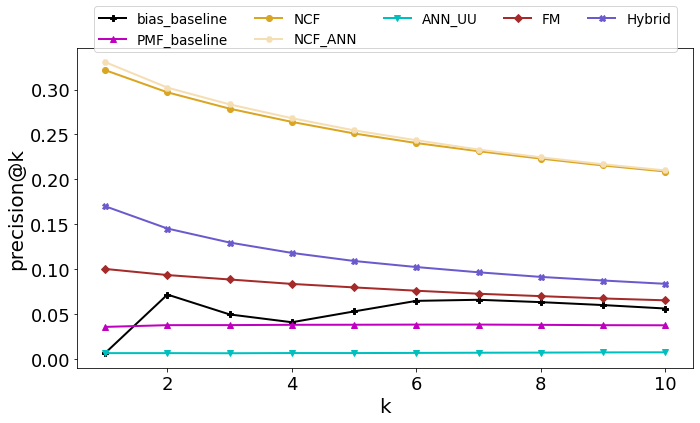

In [74]:
plot_topk_ndcg(df_,'precision')
plt.show()

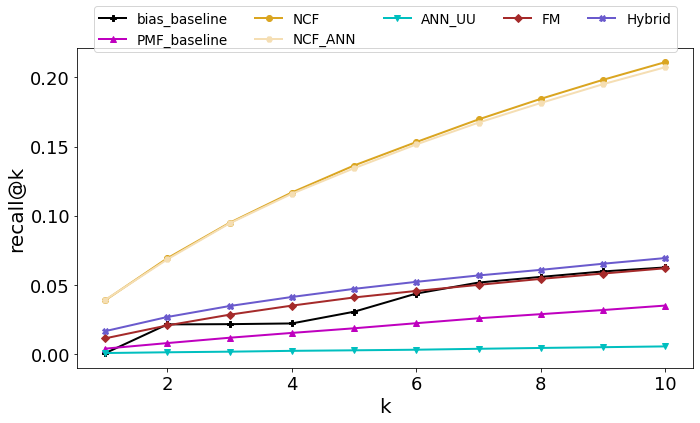

In [75]:
plot_topk_ndcg(df_,'recall')
plt.show()

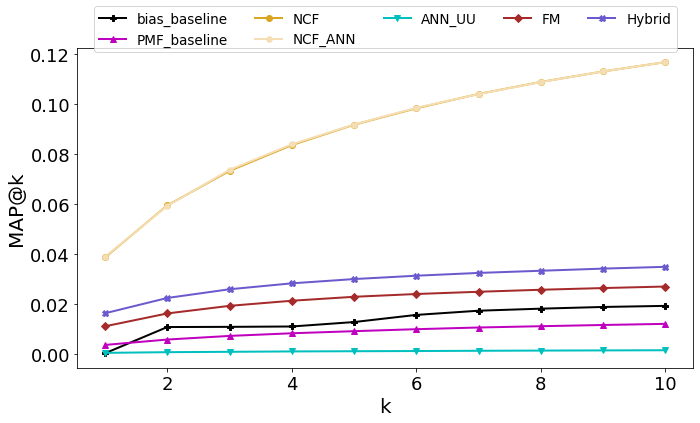

In [76]:
plot_topk_ndcg(df_,'MAP')
plt.show()

In [77]:
def get_pred_data(all_predictions,test):
  data=pd.merge(all_predictions,test,on=['userID','itemID'],how='inner')
  return(data)
def pred_rank(pred):
    pred.sort_values(['userID', 'rating'], ascending=[True, False],inplace=True)
    pred["rating_rank"] = pred.groupby("userID")["rating"].rank("min", ascending=False)
    pred.sort_values(['userID', 'prediction'], ascending=[True, False],inplace=True)
    pred["pred_rank"] = pred.groupby("userID")["prediction"].rank("min", ascending=False)
    return(pred)
def test_all_for_ndcg(pred,data):
    data.sort_values(['userID', 'prediction'], ascending=[True, False],inplace=True)
    data["pred_rank"] = data.groupby("userID")["prediction"].rank("min", ascending=False)
    pred=pred[['userID','itemID','rating_rank','rating']]
    df = pd.merge(pred, data, on=['userID','itemID'],how='inner')
    return(df)



def ndcg_k(data1,k=10):
    data1['top_10_pred']=1
    data1.loc[(data1['pred_rank']>=k) ,'top_10_pred'] = 0
    data1['top_10_rating']=1
    data1.loc[(data1['rating_rank']>=k) ,'top_10_rating'] = 0
    data1['relevance']=data1['top_10_pred']*data1['top_10_rating']
    data1['log_den']=1/(np.log2(data1['pred_rank']+1))
    data1['dcg_num']=data1['relevance']*data1['log_den']
    data1["idcg_rank"] = data1.groupby("userID")["relevance"].rank("first", ascending=False)
    data1["idcg_log"]=1/(np.log2(data1['idcg_rank']+1))
    data1['idcg_num']=data1['relevance']*data1['idcg_log']
    user_list = data1['userID'].unique()
    ndcg=0
    len_ls=data1['userID'].nunique()
    for user in user_list:
      #print(user)
        _d=data1[data1['userID']==user]
        if _d['userID'].count()==1:
            len_ls=len_ls-1
        else:
            num=np.sum(data1[data1['userID']==user]['dcg_num'])
            den=np.sum(data1[data1['userID']==user]['idcg_num'])
            if den==0:
                continue
            else:
                ndcg+=num/den
            #break
    
    ndcg=ndcg/len_ls
    return(ndcg)

def get_ndcg(all_predictions):
  pred=get_pred_data(all_predictions,test)
  pred=pred_rank(pred)
  test_all_for_ndcg_=test_all_for_ndcg(pred,all_predictions)
  lst=[]
  for i in range(10):
    lst.append([ndcg_k(test_all_for_ndcg_,k=i+1),i+1])
  return(lst)

In [ ]:
all_predictions=pd.read_csv('/content/drive/MyDrive/main_data/fm_warp.csv')
all_predictions.drop(['Unnamed: 0'],axis=1,inplace=True)
all_predictions.rename({'userId': 'userID', 'movieId': 'itemID'}, axis=1, inplace=True)
all_predictions['prediction']=5*sigmoid(all_predictions['prediction'])

In [ ]:
lst1=get_ndcg(all_predictions)
columns = ['ndcg','k']
df_ = pd.DataFrame(lst1, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/fm_warp_ndcg.csv')

In [ ]:
FM_warp_ls=evals(all_predictions,test)
columns = ['MAP','ndcg', 'precision','recall','k']
df_ = pd.DataFrame(FM_warp_ls, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/FM_warp_ls_eval1.csv')

MAP:	0.010673
NDCG:	0.000000
Precision@K:	0.094168
Recall@K:	0.010673
MAP:	0.015313
NDCG:	0.000000
Precision@K:	0.089134
Recall@K:	0.019222
MAP:	0.018067
NDCG:	0.000000
Precision@K:	0.083840
Recall@K:	0.026275
MAP:	0.020155
NDCG:	0.000000
Precision@K:	0.080476
Recall@K:	0.033000
MAP:	0.021739
NDCG:	0.000000
Precision@K:	0.077076
Recall@K:	0.039174
MAP:	0.022946
NDCG:	0.000000
Precision@K:	0.074015
Recall@K:	0.044571
MAP:	0.023893
NDCG:	0.000000
Precision@K:	0.071196
Recall@K:	0.049344
MAP:	0.024684
NDCG:	0.000000
Precision@K:	0.068808
Recall@K:	0.053567
MAP:	0.025404
NDCG:	0.000000
Precision@K:	0.066567
Recall@K:	0.058059
MAP:	0.026000
NDCG:	0.000000
Precision@K:	0.064478
Recall@K:	0.061893


In [ ]:
all_predictions=pd.read_csv('/content/drive/MyDrive/main_data/ncf_ann100_data_preds.csv')
lst1=get_ndcg(all_predictions)
columns = ['ndcg','k']
df_ = pd.DataFrame(lst1, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/ncf_ann_ndcg.csv')

In [ ]:
all_predictions=pd.read_csv('/content/drive/MyDrive/main_data/all_predictions_bias_baseline.csv')
all_predictions.drop(['Unnamed: 0','timestamp','date','year',],axis=1,inplace=True)
all_predictions.rename({'userId': 'userID', 'movieId': 'itemID','predictions':'prediction'}, axis=1, inplace=True)

In [ ]:

lst1=get_ndcg(all_predictions)
columns = ['ndcg','k']
df_ = pd.DataFrame(lst1, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/bias_baseline_ndcg.csv')
print(df_)

       ndcg   k
0  0.000000   1
1  0.005684   2
2  0.066509   3
3  0.073858   4
4  0.082935   5
5  0.114615   6
6  0.143560   7
7  0.158217   8
8  0.167012   9
9  0.174299  10


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1rTUfHwHtHNZ4DszfBD-i0Hh9VWME4bVn'

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('final_dataset.csv')  
all_predictions = pd.read_csv('final_dataset.csv')
all_predictions.rename({'userId': 'userID', 'movieId': 'itemID','predictions':'prediction'}, axis=1, inplace=True)
lst1=get_ndcg(all_predictions)
columns = ['ndcg','k']
df_ = pd.DataFrame(lst1, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/ann_uu_ndcg.csv')
print(df_)

       ndcg   k
0  0.000000   1
1  0.001582   2
2  0.003565   3
3  0.005288   4
4  0.007250   5
5  0.009095   6
6  0.011045   7
7  0.013079   8
8  0.015480   9
9  0.017951  10


In [ ]:
all_predictions=pd.read_csv('/content/drive/MyDrive/main_data/ncf_all_data_preds.csv')
lst1=get_ndcg(all_predictions)
columns = ['ndcg','k']
df_ = pd.DataFrame(lst1, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/ncf_all_ndcg.csv')
print(df_)

       ndcg   k
0  0.000000   1
1  0.145900   2
2  0.247379   3
3  0.314453   4
4  0.360491   5
5  0.392578   6
6  0.415256   7
7  0.432048   8
8  0.445885   9
9  0.455953  10


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1AVbw5s6aZFLZGUlupHDbASeXugc869fA'

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('final_dataset.csv')  
all_predictions = pd.read_csv('final_dataset.csv')

all_predictions.rename({'userId': 'userID', 'movieId': 'itemID','predictions':'prediction'}, axis=1, inplace=True)
all_predictions.drop('rating',axis=1,inplace=True)
lst1=get_ndcg(all_predictions)
columns = ['ndcg','k']
df_ = pd.DataFrame(lst1, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/baseline_mf_ndcg.csv')
print(df_)

       ndcg   k
0  0.000000   1
1  0.020933   2
2  0.038805   3
3  0.053227   4
4  0.065372   5
5  0.076619   6
6  0.086413   7
7  0.094583   8
8  0.101488   9
9  0.107493  10


In [80]:
pre='/content/drive/MyDrive/main_data/'
post='.csv'
models=['bias_baseline','PMF_baseline','NCF','NCF_ANN','ANN_UU','FM','Hybrid']

files=['bias_baseline_ndcg','baseline_mf_ndcg','ncf_all_ndcg','ncf_ann_ndcg','ann_uu_ndcg','fmj_ndcg','ndcg_new_hybrid']
columns = ['ndcg','k']
df_ = pd.DataFrame(columns=columns)
for model,file in zip(models,files):
  df=pd.read_csv(pre+file+post)
  df['model']=model
  df_=df_.append(df)

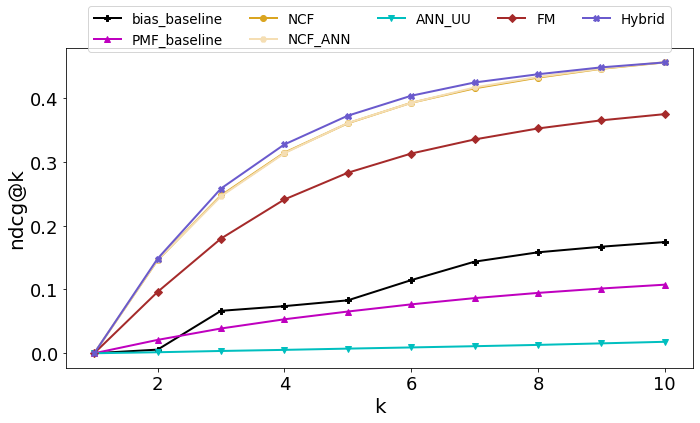

In [81]:
plot_topk_ndcg(df_,'ndcg')
plt.show()

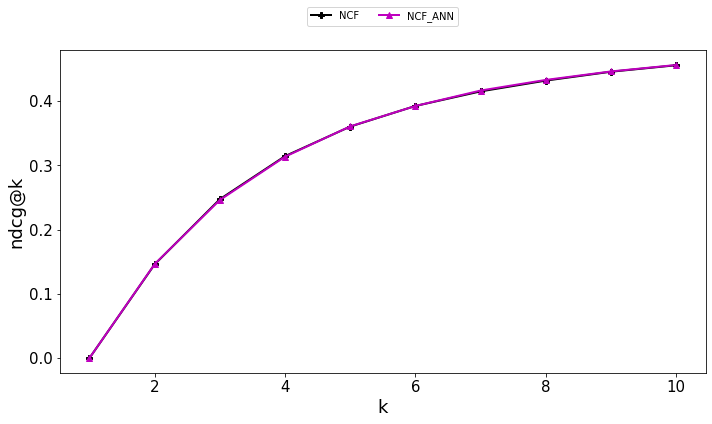

In [ ]:
pre='/content/drive/MyDrive/main_data/'
post='.csv'
models=['NCF','NCF_ANN']
files=['ncf_all_ndcg','ncf_ann_ndcg']
columns = ['ndcg','k']
df_ = pd.DataFrame(columns=columns)
for model,file in zip(models,files):
  df=pd.read_csv(pre+file+post)
  df['model']=model
  df_=df_.append(df)

plot_topk_ndcg(df_,'ndcg')

In [ ]:
pre='/content/drive/MyDrive/main_data/'
post='_eval1.csv'
models=['NCF','NCF_ANN']
files=['ncf_all_ls','ann_ncf']

## Precision - Recall for ANN-NCF, NCF

In [ ]:
columns = ['MAP','ndcg', 'precision','recall','k','model']
df_ = pd.DataFrame(columns=columns)
for model,file in zip(models,files):
  df=pd.read_csv(pre+file+post)
  df['model']=model
  df_=df_.append(df)


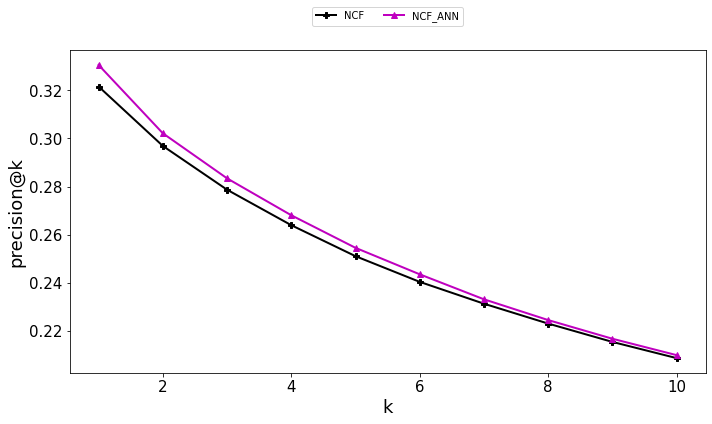

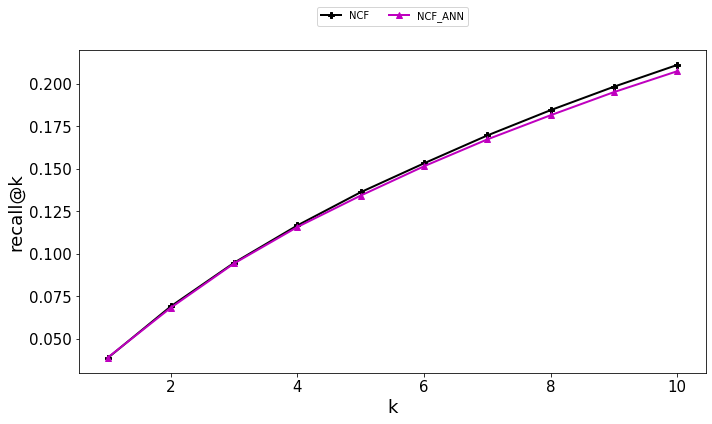

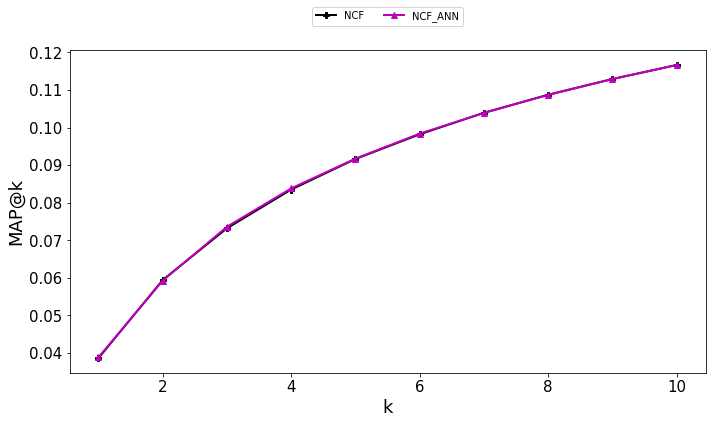

In [ ]:
plot_topk_ndcg(df_,'precision')
plot_topk_ndcg(df_,'recall')
plot_topk_ndcg(df_,'MAP')

### Coverage - User and catalog calculations

In [43]:
def user_coverage(all_predictions,threshold=3.5,n=10):
  sub=all_predictions[all_predictions['prediction']>=threshold]
  user_count=sub.groupby('userID', as_index=False).agg(num_movies=('itemID','count'))
  user_count_sub=user_count[user_count['num_movies']>=n]
  return(len(user_count_sub)/all_predictions['userID'].nunique())

def catalogue_coverage(all_predictions,threshold=3.5,n=10):
  sub=all_predictions[all_predictions['prediction']>=threshold]
  movie_count=sub.groupby('itemID', as_index=False).agg(num_users=('userID','count'))
  movie_count_sub=movie_count[movie_count['num_users']>=n]
  return(len(movie_count_sub)/all_predictions['itemID'].nunique())


In [44]:
def coverage(all_predictions,test):
  lst=[]
  for k in range(10):
    i=(k+1)*10
    TOP_K = i
    user_cov = user_coverage(all_predictions,threshold=3.5,n=i)
    cat_cov = catalogue_coverage(all_predictions,threshold=3.5,n=i)

    lst.append([user_cov,cat_cov,i])
  return(lst)

In [45]:
all_predictions=pd.read_csv('/content/drive/MyDrive/main_data/new_hybrid_preds.csv')

all_predictions['prediction'] = all_predictions['prediction']*5
hybrid_cov=coverage(all_predictions,test)


columns = ['user_cov','cat_cov', 'k']
dfh = pd.DataFrame(hybrid_cov, columns=columns)
dfh.to_csv('/content/drive/MyDrive/main_data/hybrid_cov.csv')
dfh

,user_cov,cat_cov,k
0,0.873987,0.860381,10
1,0.632688,0.786945,20
2,0.352341,0.732548,30
3,0.154239,0.682684,40
4,0.065176,0.652765,50
5,0.027892,0.620127,60
6,0.013493,0.587489,70
7,0.007533,0.549411,80
8,0.004482,0.526745,90
9,0.002861,0.512239,100


In [ ]:
all_predictions=pd.read_csv('/content/drive/MyDrive/main_data/ncf_ann100_data_preds.csv')
all_predictions['prediction']=all_predictions['prediction']*5
ann100_ncf_cov=coverage(all_predictions,test)


columns = ['user_cov','cat_cov', 'k']
df_ = pd.DataFrame(ann100_ncf_cov, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/ann100_ncf_cov.csv')
df_

,user_cov,cat_cov,k
0,0.899018,0.848595,10
1,0.625060,0.769719,20
2,0.304615,0.704442,30
3,0.106274,0.664551,40
4,0.034376,0.625567,50
5,0.013731,0.598368,60
6,0.006723,0.554850,70
7,0.003719,0.524025,80
8,0.002241,0.503173,90
9,0.001430,0.485041,100


In [ ]:
all_predictions=pd.read_csv('/content/drive/MyDrive/main_data/all_predictions_bias_baseline.csv')
all_predictions.drop(['Unnamed: 0','timestamp','date','year',],axis=1,inplace=True)
all_predictions.rename({'userId': 'userID', 'movieId': 'itemID','predictions':'prediction'}, axis=1, inplace=True)
bias_baseline_cov=coverage(all_predictions,test)
columns = ['user_cov','cat_cov', 'k']
df_ = pd.DataFrame(bias_baseline_cov, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/bias_baseline_cov.csv')
df_

,user_cov,cat_cov,k
0,0.985744,0.970988,10
1,0.982454,0.963735,20
2,0.980452,0.953762,30
3,0.978926,0.949229,40
4,0.977115,0.945603,50
5,0.975064,0.943790,60
6,0.973443,0.939257,70
7,0.971775,0.932004,80
8,0.970344,0.922937,90
9,0.968628,0.915684,100


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
id = '1rTUfHwHtHNZ4DszfBD-i0Hh9VWME4bVn'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('final_dataset.csv')  
all_predictions = pd.read_csv('final_dataset.csv')
all_predictions.rename({'userId': 'userID', 'movieId': 'itemID','predictions':'prediction'}, axis=1, inplace=True)

ann_uu_cov=coverage(all_predictions,test)
columns = ['user_cov','cat_cov', 'k']
df_ = pd.DataFrame(ann_uu_cov, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/ann_uu_cov.csv')
df_

,user_cov,cat_cov,k
0,0.968151,1.0,10
1,0.955278,1.0,20
2,0.945933,1.0,30
3,0.937351,1.0,40
4,0.928531,1.0,50
5,0.920092,1.0,60
6,0.912940,1.0,70
7,0.905931,1.0,80
8,0.899876,1.0,90
9,0.893535,1.0,100


In [ ]:
all_predictions=pd.read_csv('/content/drive/MyDrive/main_data/ncf_all_data_preds.csv')
all_predictions['prediction']=all_predictions['prediction']*5
all_ncf_cov=coverage(all_predictions,test)


columns = ['user_cov','cat_cov', 'k']
df_ = pd.DataFrame(all_ncf_cov, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/all_ncf_cov.csv')
df_

,user_cov,cat_cov,k
0,0.918137,0.871260,10
1,0.626013,0.805984,20
2,0.284257,0.743427,30
3,0.098837,0.703536,40
4,0.038953,0.653672,50
5,0.015686,0.631006,60
6,0.006055,0.596555,70
7,0.002527,0.564823,80
8,0.001478,0.534905,90
9,0.000763,0.521306,100


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1AVbw5s6aZFLZGUlupHDbASeXugc869fA'

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('final_dataset.csv')  
all_predictions = pd.read_csv('final_dataset.csv')

all_predictions.rename({'userId': 'userID', 'movieId': 'itemID','predictions':'prediction'}, axis=1, inplace=True)
all_predictions.drop('rating',axis=1,inplace=True)
mf_baseline_cov=coverage(all_predictions,test)


columns = ['user_cov','cat_cov', 'k']
df_ = pd.DataFrame(mf_baseline_cov, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/mf_baseline_cov.csv')
df_

,user_cov,cat_cov,k
0,0.952942,1.0,10
1,0.934681,1.0,20
2,0.918947,1.0,30
3,0.904501,1.0,40
4,0.889148,1.0,50
5,0.873653,1.0,60
6,0.862020,1.0,70
7,0.848098,1.0,80
8,0.835129,1.0,90
9,0.822018,1.0,100


In [ ]:
all_predictions=pd.read_csv('/content/drive/MyDrive/main_data/fm_warp.csv')
all_predictions.drop(['Unnamed: 0'],axis=1,inplace=True)
all_predictions.rename({'userId': 'userID', 'movieId': 'itemID'}, axis=1, inplace=True)
all_predictions['prediction']=5*sigmoid(all_predictions['prediction'])
fm_warp_cov=coverage(all_predictions,test)


columns = ['user_cov','cat_cov', 'k']
df_ = pd.DataFrame(fm_warp_cov, columns=columns)
df_.to_csv('/content/drive/MyDrive/main_data/fm_warp_cov.csv')
df_


,user_cov,cat_cov,k
0,0.614237,0.948323,10
1,0.500906,0.920218,20
2,0.416992,0.892112,30
3,0.347716,0.868540,40
4,0.285067,0.837715,50
5,0.231334,0.819583,60
6,0.184991,0.791478,70
7,0.145323,0.762466,80
8,0.112377,0.742520,90
9,0.084056,0.720762,100


In [82]:
pre='/content/drive/MyDrive/main_data/'
post='.csv'
models=['NCF','NCF_ANN','FM','bias_baseline','pmf_baseline','Hybrid','ANN_UU']
files=['all_ncf_cov','ann100_ncf_cov','fm_warp_cov','bias_baseline_cov','mf_baseline_cov','hybrid_cov','ann_uu_cov']
columns = ['user_cov','cat_cov', 'k']
df_ = pd.DataFrame(columns=columns)
for model,file in zip(models,files):
  df=pd.read_csv(pre+file+post)
  df['model']=model
  df_=df_.append(df)

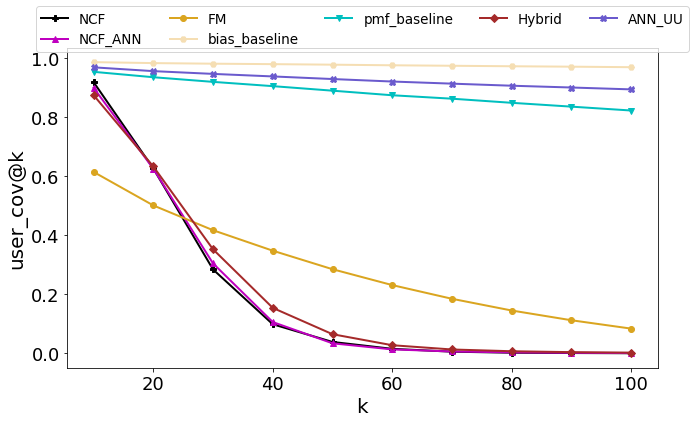

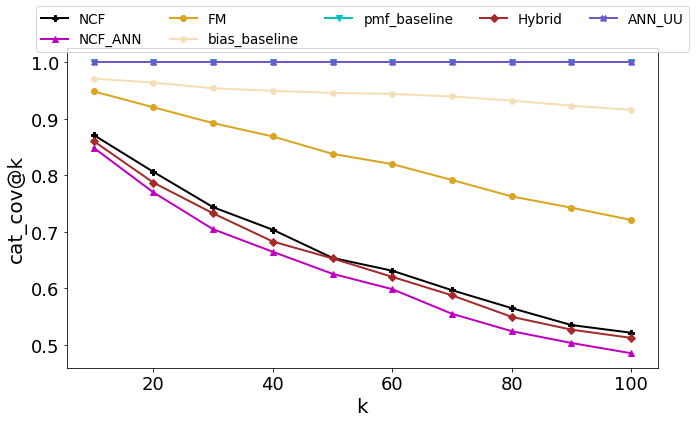

In [83]:
plot_topk_ndcg(df_,'user_cov')
plot_topk_ndcg(df_,'cat_cov')
plt.show()